<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-crypto/blob/main/ES_CR_Cap%C3%ADtulo_06_Manejo_del_Riesgo_en_el_Porfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>


# Control del riesgo en el portfolio

### Resumen
* Estrategia de ruptura del Drawdown (DDB)
* Cartera de Crypto DDB
* Cartera de ruptura del Drawdown

<br>


💰 Únete a la comunidad de [Discord](https://discord.gg/z3dx5XpkX4)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.es/Python-para-finanzas-trading-algor%C3%ADtmico-ebook/dp/B0BT4ZS9Q3/)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español


In [1]:
!pip install ta
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=370599e5df346e04bc922688fb79fb0e1b4b0c104589b2c26e2a7924c2f13ddf
  Stored in directory: /root/.cache/pip/wheels/1b/81/50/db21d9643326c61dd6fee1dc2562d8351ee7753164c24ead38
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 594 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [4]:
def BackTest(serie, annualiazed_scalar=252):
  global serie_print

  # FUNCTION TO BUT THE RIGHT DATE FORMAT
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df

  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  try:
    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  except:
    # Put the right date format
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

In [5]:
def breakout(name, cost=0.001, duration=7, dd_break=None):
  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown
    
  def preprocessing(name):

    # Import the data
    df = pd.read_csv(f"{name}", delimiter="\t", index_col="<DATE>", parse_dates=True)

    # Delete the two last columns
    df = df.iloc[:,:-2]

    # Rename
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "name"

    return df

  df = preprocessing(name)
  df["resistance"] = df["close"].rolling(30).max().shift(3)
  df["support"] = df["close"].rolling(30).min().shift(3)

  distance = 0.5/100

  # Shift the values
  df["Close Yesterday"] = df["close"].shift(1)
  df["Resistance Yesterday"] = df["resistance"].shift(1)
  df["signal_long"] = np.nan

  df.loc[(df["close"] > df["resistance"]*(1+distance)) &\
         (df["Close Yesterday"] < df["Resistance Yesterday"]), "signal_long"] = 1

  df["signal_long"] = df["signal_long"].fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy

  df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal_long"].shift(duration))
  # df["return"] = (df["pct"] + df["pct"].shift(9) + df["pct"].shift(8) + df["pct"].shift(7) + df["pct"].shift(6)\
  #                 + df["pct"].shift(5)+ df["pct"].shift(4)+ df["pct"].shift(3)+ df["pct"].shift(2)\
  #                 + df["pct"].shift(1)) * (df["signal_long"].shift(10))
  
  df.loc[df["signal_long"]==1,"return"]=df["return"]-cost

  if dd_break!=None:
    df["drawdown"] = drawdown_function(df["return"])
    df.loc[df["drawdown"].shift(1)<-dd_break, "return"] = 0

  return df["return"]

# Estrategia de ruptura del Drawdown

<p><img alt="Colaboratory logo"  src="https://www.quantreo.com/wp-content/uploads/2022/01/Capture-decran-2022-01-13-a-18.33.13.png" align="left" hspace="10px" vspace="0px"></p>


[*********************100%***********************]  1 of 1 completed


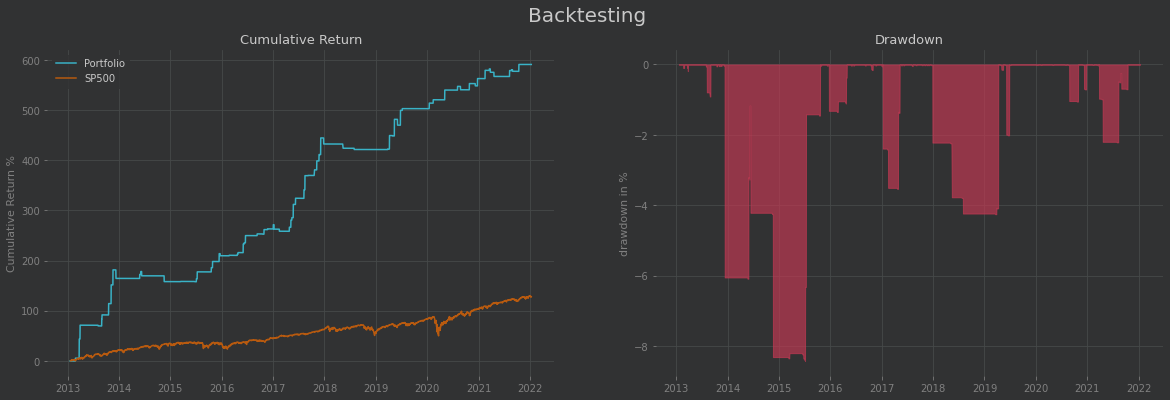

Sortino: 0.455
Beta: -0.037
Alpha: 11.248 %
MaxDrawdown: 8.422 %
[*********************100%***********************]  1 of 1 completed


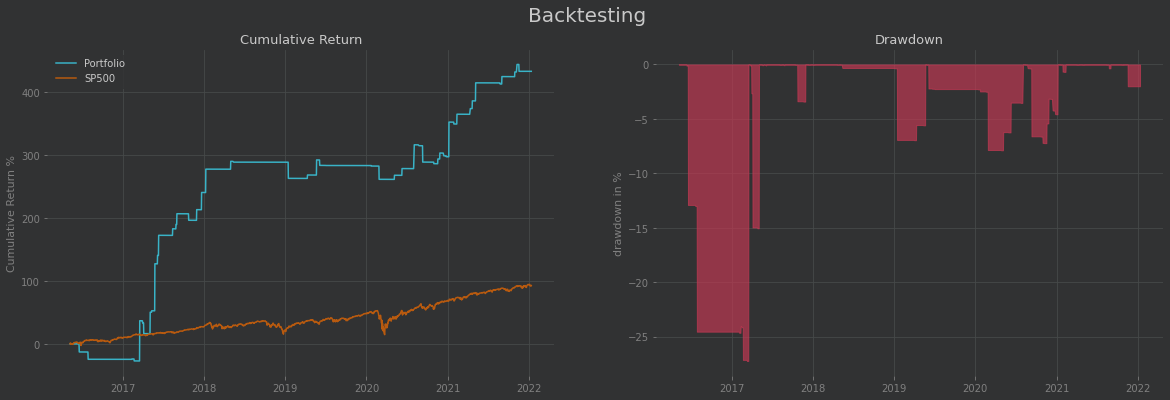

Sortino: 0.318
Beta: 0.108
Alpha: 12.17 %
MaxDrawdown: 27.231 %
[*********************100%***********************]  1 of 1 completed


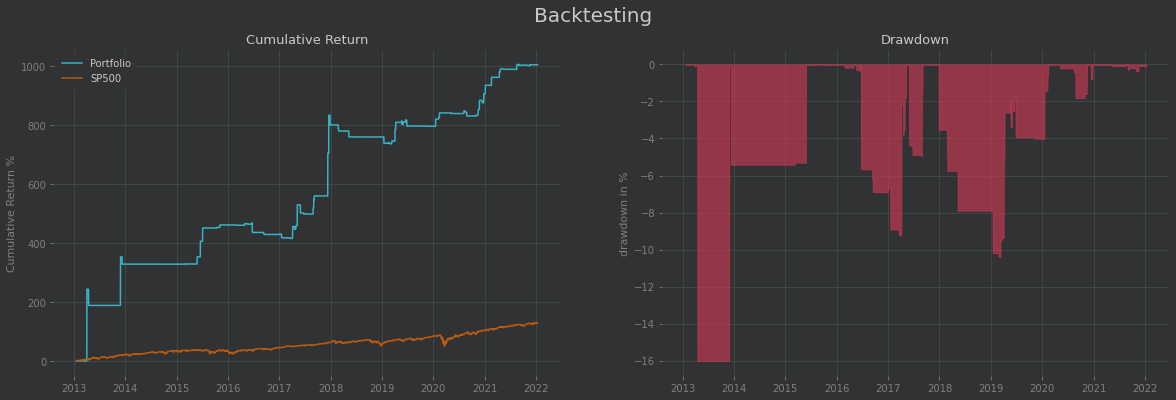

Sortino: 0.28
Beta: 0.0
Alpha: 17.555 %
MaxDrawdown: 16.022 %
[*********************100%***********************]  1 of 1 completed


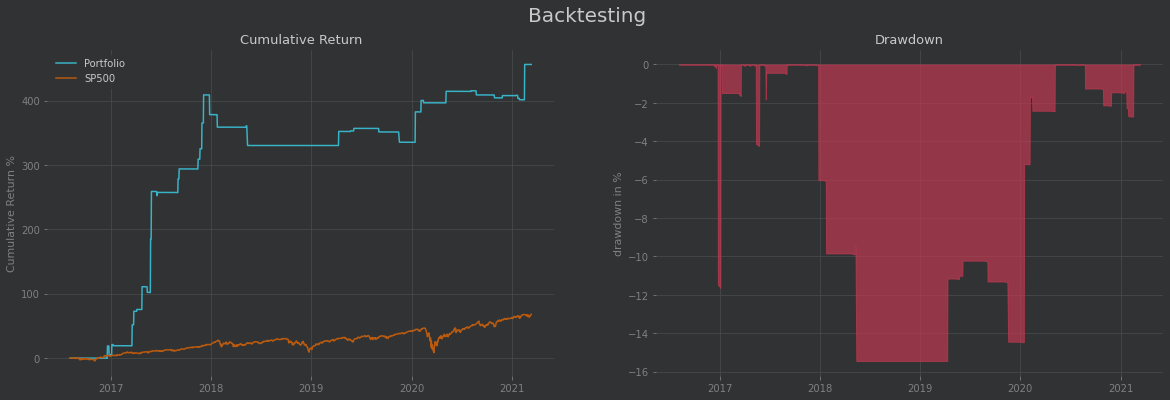

Sortino: 0.356
Beta: -0.019
Alpha: 18.129 %
MaxDrawdown: 15.45 %
[*********************100%***********************]  1 of 1 completed


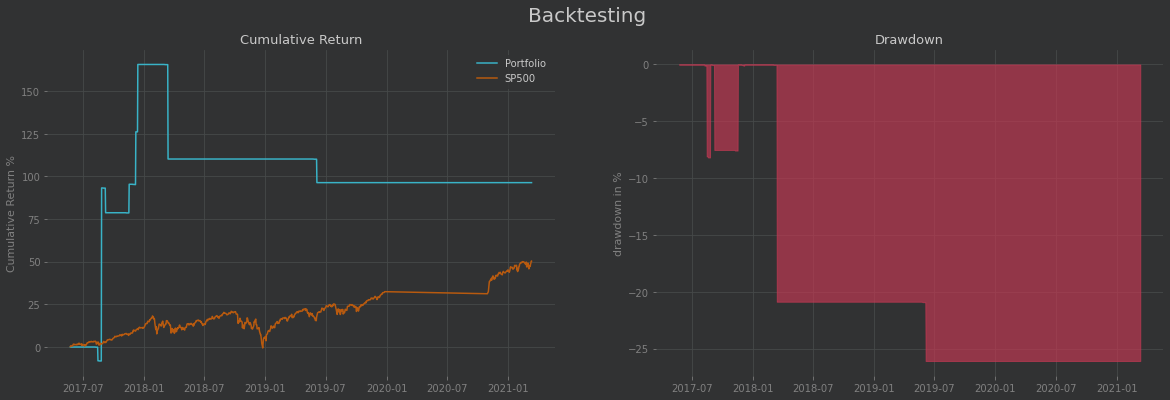

Sortino: 0.054
Beta: 0.043
Alpha: 5.999 %
MaxDrawdown: 26.076 %


In [11]:
# DDB to 15% but we need to take the SL into account
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}USD_D1.csv", duration=7, dd_break=0.15)
  returns = pd.concat((returns,ret),axis=1)
  BackTest(ret, 52)

# Cartera de estrategias en Crypto

In [12]:
def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

[*********************100%***********************]  1 of 1 completed


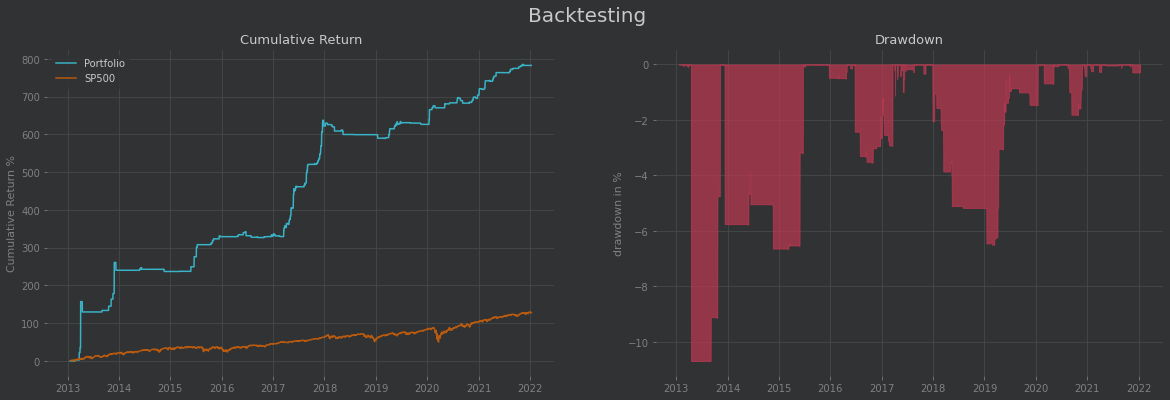

Sortino: 0.671
Beta: 0.006
Alpha: 13.469 %
MaxDrawdown: 10.691 %


In [13]:
# DDB to 15% but we need to take the SL into account
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}USD_D1.csv", duration=7, dd_break=0.15)
  returns = pd.concat((returns,ret),axis=1)

# Create empty DataFrame
returns_ = pd.DataFrame()

# Number of asset in the portfolio
returns_["count"] = returns.shape[1] - returns.isna().sum(axis=1)

# Portfolio creation
returns_["return"] = returns.sum(axis=1) / returns_["count"]

# Drawdown computation
returns_["drawdown"] = drawdown_function(returns_["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
returns_.loc[returns_["drawdown"].shift(1)<-0.1, "return"] = 0

BackTest(returns_["return"],52)

# Cartera de estrategias en Crypto con Drawdown Break


[*********************100%***********************]  1 of 1 completed


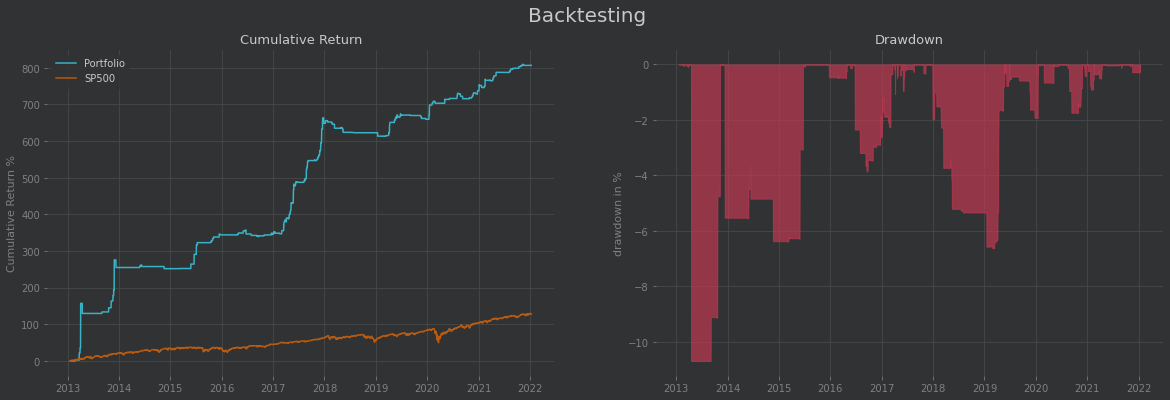

Sortino: 0.707
Beta: 0.002
Alpha: 13.935 %
MaxDrawdown: 10.691 %


In [17]:
# DDB to 15% but we need to take the SL into account
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}USD_D1.csv", duration=7)
  returns = pd.concat((returns,ret),axis=1)

# Create empty DataFrame
returns_ = pd.DataFrame()

# Number of asset in the portfolio
returns_["count"] = returns.shape[1] - returns.isna().sum(axis=1)

# Portfolio creation
returns_["return"] = returns.sum(axis=1) / returns_["count"]

# Drawdown computation
returns_["drawdown"] = drawdown_function(returns_["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
returns_.loc[returns_["drawdown"].shift(1)<-0.1, "return"] = 0

BackTest(returns_["return"],52)